In [100]:
import time
import pickle

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import Levenshtein

from sklearn.decomposition import PCA
from gensim.models import Doc2Vec

from manage import jsonAttempts2data, jsonExercises2data
from code2aes import Code2Aes
from aes2vec import learnModel, inferVectors, read_corpus, data2cor


In this section we gonna load our data and model to get some visualisation of them
In order to reproduce this work, all of the data need to be in the same format as ours.

In [101]:
# Data importations
NC1014 = jsonAttempts2data('Datasets/NewCaledonia_1014.json')
NCExercises = jsonExercises2data('Datasets/NewCaledonia_exercises.json')
NC5690 = jsonAttempts2data('Datasets/NewCaledonia_5690.json')

In [102]:
# There is multiple 
NCExercises_corrected = {}
list_used = []
for ex in NCExercises:
    if NCExercises[ex]["funcname"] not in list_used:
        list_used.append(NCExercises[ex]["funcname"])
        NCExercises_corrected[ex] = NCExercises[ex]

56

In [103]:
# Dictionary that maps the encoded exercise to its real name
exercice_name_dict = {}
list_exo = list(NCExercises.values())
for exo in list_exo:
    # key : encoded name, value : real name of exercise
    exercice_name_dict[exo["exo_name"]] = exo["funcname"] 
list_exo = list(set(exercice_name_dict.values()))

In [104]:
# Dictionary that maps the real name to the encoded exercise
exercice_name_dict_inv = {}
for exo in exercice_name_dict:
    if exercice_name_dict[exo] not in exercice_name_dict_inv: 
        exercice_name_dict_inv[exercice_name_dict[exo]] = [exo]
    else:
        exercice_name_dict_inv[exercice_name_dict[exo]].append(exo)

# Embedding methode

In [105]:
def loadModel(model_path):
    """Load a saved Doc2Vec model from disk"""
    model = Doc2Vec.load(model_path)
    return model

In [106]:
def get_all_inferVectors(model, data):
    """Infer new embedding vectors of full the dataset given a pre-trained model
    - model          : the pre-trained model (typically obtaind by learnModel())
    - data           : the dataset containing learners' attempts
    """
    for i in range(len(data)):
        if data[i]["eval_set"] != "test":
            data[i]["eval_set"] = "test"
    res = inferVectors(model,data)
    return res

In [107]:
def get_correction(data_correction):
    """
    We suppose that data_correction has the same format as our data: NCExercises.
    This function transforms data_correction into a list of attempts.
    Each attempt is a dictionary with level 2 AES, the exercise code, and the eval set for inference.
    
    - data_correction : dict that containt the correction, exercise name mainly
    - return list
    """
    correction_list = []
    for exercise in data_correction:
        correction_to_aes = {}
        correction_to_aes["upload"] = data_correction[exercise]["solution"]
        correction_to_aes["exercise_name"] = exercise
        correction_list.append(correction_to_aes)
        
    list_aes = []
    for exercise in correction_list:
         list_aes.append(Code2Aes(exercise,data_correction)
                        )

    for i in range(len(list_aes)):
        correction_list[i]["aes2"] = list_aes[i]
        correction_list[i]["eval_set"] = "test"
    return correction_list

In [108]:
# Load our Doc2vec model trained by data : NC590
model_path = "Datasets/model_NC590"
model = loadModel(model_path)

In [109]:
# list of data of correction of exercise useful for inference
correction_list = get_correction(NCExercises_corrected)

In [110]:
# We get our embedding here and we calcute the inference time


compute_emb = True # Put a False if you want to recalculate your embedding

if compute_emb:
    results = list(np.load('Datasets/results.npy'))
    results_corr = list(np.load('Datasets/results_corr.npy'))
else:
    start_time = time.time() 
    results = get_all_inferVectors(model, NC5690)
    results_corr = get_all_inferVectors(model, correction_list)
    end_time = time.time()  
    execution_time = end_time - start_time 
    print(f"execution time : {execution_time/60} minutes")

In [111]:
def get_data_visualisation(data, dict_decoded = exercice_name_dict, name_encoded = True):
    """
    From the data, we creat many dictionnary to get, exercise by exercise, the embedding, the correction, the timestamp, the student id and the attemp
    
    - data : dictionnary
    - name_encoded : bool var. Put True if exo name is encoded
    - dict_decoded : dictionnary used to decoded the exo name
    - return list of dictionnary used for visualisation
    """
    dict_exo_trajectory = {} # keep a list of the embedding of attemps
    dict_exo_trajectory_correct = {} # keep a list of value 0 and 1. 0 if attemp is wrong 1 if good
    dict_exo_trajectory_date = {}  # keep a list of the timestamps of attemps
    dict_exo_trajectory_student = {}  # keep a list of student id 
    dict_exo_trajectory_code = {}  # keep a list of attemps
    for i, attemp in enumerate(data):
        if name_encoded: # if exo name is encoded
            exo_encoded = attemp["exercise_name"]
            exo = dict_decoded[exo_encoded]
        else:
            exo = attemp["exercise_name"]
        if exo not in dict_exo_trajectory:
            # creat an empty list where we gonna keep all the data, exercise by exercise
            dict_exo_trajectory[exo] = []
            dict_exo_trajectory_correct[exo] = []
            dict_exo_trajectory_date[exo] = []
            dict_exo_trajectory_student[exo] = []
            dict_exo_trajectory_code[exo] = []
        dict_exo_trajectory[exo].append(results[i]) # get embedding
        dict_exo_trajectory_correct[exo].append(int(attemp["correct"])) # get if attemp is wrong or good
        dict_exo_trajectory_date[exo].append(attemp["date"]) # get timestamp
        dict_exo_trajectory_student[exo].append(attemp["user"]) # get user id
        dict_exo_trajectory_code[exo].append(attemp["upload"]) # get the attemp
    data_visualisation = [dict_exo_trajectory, dict_exo_trajectory_correct, dict_exo_trajectory_date, dict_exo_trajectory_student, dict_exo_trajectory_code]
    return data_visualisation


def sort_data(data_visualisation):
    """
    Sort data by the timestamps of attemps
    
    - data_visualisation : list of dictionnary that contain embbeding, correction, date, student id and attemps
    - return data_visualisation : same list but sorted by the date
    """
    
    # Decompose the list if different dictionnary
    trajectory, correct, date, student, code = data_visualisation
    for exo in trajectory.keys():
        list_emb = trajectory[exo]
        valeurs_alpha = correct[exo]
        unique_labels = student[exo]
        list_date = date[exo]
        list_code = code[exo]
        if list_emb != []:
            data_combined = zip(list_date, list_emb, valeurs_alpha, unique_labels, list_code)
            # Sort data by theirs timestamps
            data_combined = sorted(data_combined, key=lambda x: x[0])
            # Distribute the sorted elements back into the original lists
            list_date, list_emb, valeurs_alpha, unique_labels, list_code = zip(*data_combined)
            # Remplace old values by sorted values
            trajectory[exo] = list(list_emb)
            correct[exo] = list(valeurs_alpha)
            student[exo] = list(unique_labels)
            date[exo] = list(list_date)
            code[exo] = list(list_code)
    data_visualisation = trajectory, correct, date, student, code 
    return data_visualisation


def correction_in_attemps(data_visualisation, data_correction, dict_decoded = exercice_name_dict, encoded_exo = True):
    """
    Add correction in all of the atemps, exercise by exercise
    
    - data_visualisation : list of dictionnary that contain embbeding, correction, date, student id and attemps
    - data_correction : dict that containt the correction, exercise name mainly
    - exercice_name_dict : dictionnary used to decod the encoded exercise name
    - Return data_visualisation : same list but with correction added
    """
    trajectory, correct, date, student, code = data_visualisation
    for i, exo_name in enumerate(data_correction):
        correction_prof = data_correction[exo_name]["solution"]
        if encoded_exo:
            exo_name = dict_decoded[exo_name]
        trajectory[exo_name].append(results_corr[i]) # Add the embedding of the correction
        correct[exo_name].append(1) # Add 1. We considere this attemp as good
        student[exo_name].append("correction") # Add the label correction instead of user id
        date[exo_name].append(date) # Add random date, not important
        code[exo_name].append(correction_prof) # Add the code
    data_visualisation = trajectory, correct, date, student, code 
    return data_visualisation 

def get_data_visualisation_completed(data, data_correction):
    """
    Re-use all of the previous function to get the final data for visualisation
    """
    data_visualisation = get_data_visualisation(data)
    data_visualisation = sort_data(data_visualisation)   
    data_visualisation = correction_in_attemps(data_visualisation, data_correction)
    return data_visualisation

In [112]:
data_visualisation = get_data_visualisation_completed(NC5690, NCExercises_corrected)

In [113]:
saved_data = False # Put at True if you want to save the data
if saved_data:
    with open('Datasets\data_visualisation.pkl', 'wb') as fichier:
        pickle.dump(data_visualisation, fichier)
else:
    with open('Datasets\data_visualisation.pkl', 'rb') as fichier:
        data_visualisation = pickle.load(fichier)

In [114]:
def plot_data_PCA(data_visualisation, max_student = 10, max_attemps = 40):
    """
    Plot the trajectory of attemps, exercise by exercise
    
    - data_visualisation : list of dictionnary that contain embbeding, correction, date, student id and attemps
    - max_student : number max of students we can find by exercise
    - max_attemps : number max of attemps we can find by exercise
    """
    trajectory, correct, date, student, code = data_visualisation
    for exo in trajectory.keys():
        list_emb = trajectory[exo] 
        # Control the transparency of the points. 
        # If 1, the point won't be transparent, else he will be a bit transparent in the graph
        valeurs_alpha = correct[exo] 
        unique_labels = student[exo] # list of different label : id_student and correction
        list_date = date[exo]
        # To ensure a readable graph, we limit the number of students and attempts
        if len(set(unique_labels)) < max_student and len(list_emb) < max_attemps:
            data_array = np.array(list_emb)
            n_samples = data_array.shape[0]
            perplexity = min(n_samples - 1, 30)  

            # Utiliser t-SNE avec perplexité appropriée
            pca = PCA(n_components=2, random_state=42)
            X_transformed = pca.fit_transform(data_array)

            # Label
            cmap = plt.cm.tab10
            label_color_map = {label: cmap(i) for i, label in enumerate(np.unique(unique_labels))}
            alpha_values = [0.2 if val == 0 else 1 for val in valeurs_alpha]

            # Create a new figure for each exercise
            plt.figure()

            # Plot all points at once
            plotted_labels = set()  
            for label in unique_labels:
                if label not in plotted_labels: 
                    indices = [i for i, l in enumerate(unique_labels) if l == label]
                    # Select the alpha values corresponding to the indices
                    alpha_values_subset = [alpha_values[i] for i in indices] 
                    plt.scatter(X_transformed[indices, 0], X_transformed[indices, 1], alpha=alpha_values_subset, color=label_color_map[label], label=label, s=50)
                    # Add the label to the set of labels already added
                    plotted_labels.add(label) 

                    # Add arrows by connecting each consecutive point
                    for i in range(len(indices) - 1):
                        premier_point = (X_transformed[indices[i], 0], X_transformed[indices[i], 1])
                        dernier_point = (X_transformed[indices[i + 1], 0], X_transformed[indices[i + 1], 1])
                        plt.annotate('', xy=dernier_point, xytext=premier_point,
                                     arrowprops=dict(facecolor=label_color_map[label], edgecolor=label_color_map[label], arrowstyle='->', linewidth=1))

            # Add legend
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.title(f"Exercice {exo}")

            # Show the plot for this exercise
            plt.show()


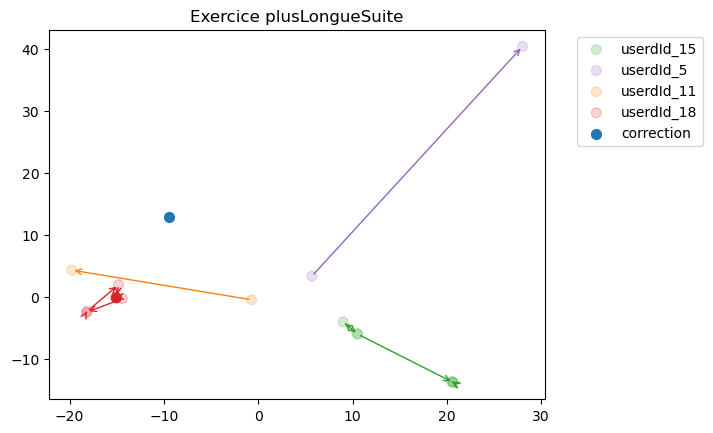

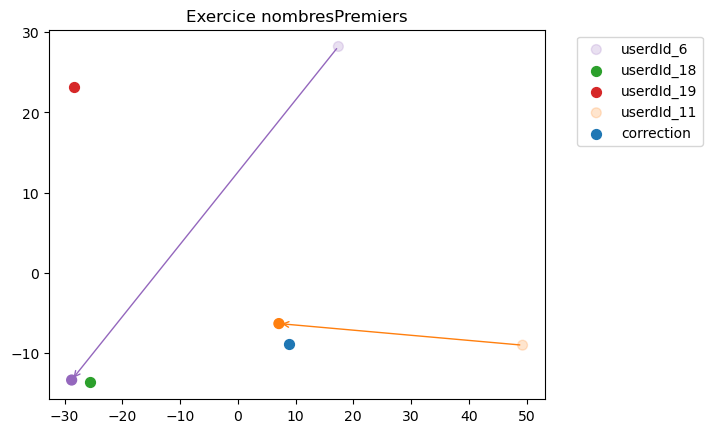

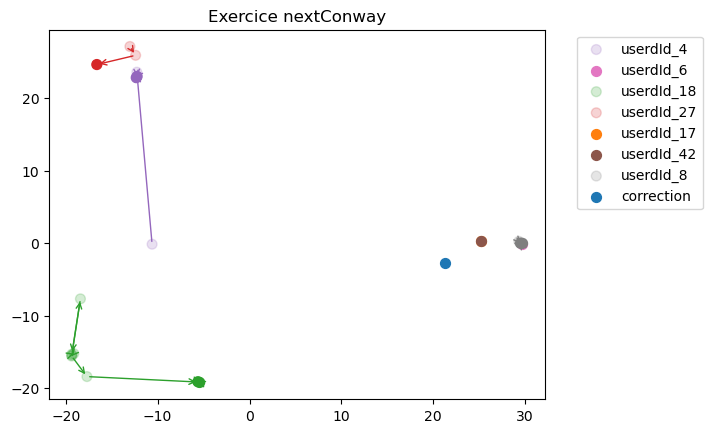

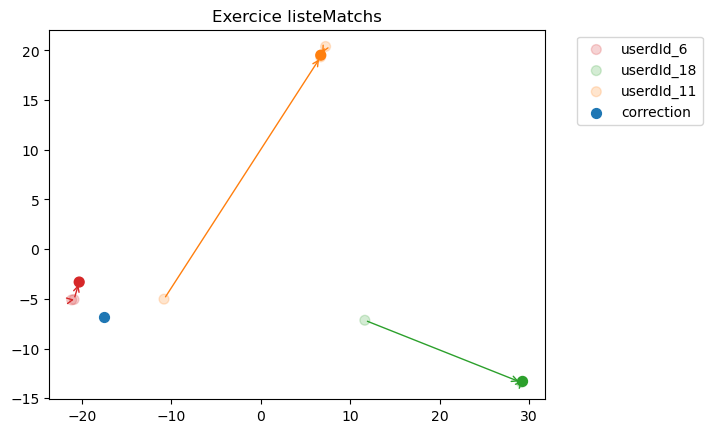


KeyboardInterrupt



In [115]:
plot_data_PCA(data_visualisation)

We saw in this section the visualisation of the trajectory of students's attemps using the pure embedding methode. We will see In the next section, we will see the similarity methode using the embedding.

# Compute the trajectories for cos² and lev

In [127]:
def compute_trajectory_cos(data, data_corr, embedding = results, embedding_corr = results_corr, dict_decoded = exercice_name_dict, name_encoded = True):
    """
    Creat a dictionnary of trajectories (composed of embedding)
    
    """
    trajec = {}
    for i, attemps in enumerate(data):
        if name_encoded:
            exercise = dict_decoded[attemps["exercise_name"]]
        else:
            exercise = attemps["exercise_name"]
        student = attemps["user"]
        if exercise not in trajec:
            trajec[exercise] = {}
        if student not in trajec[exercise]:
            trajec[exercise][student] = []
        trajec[exercise][student].append(embedding[i])
    for i, exercise in enumerate(data_corr):
        if name_encoded:
            exercise = dict_decoded[exercise]
        trajec[exercise]["correction"] = embedding_corr[i]
    return trajec



# similarity measure 
def cos2(x,y):
    """
    Similarity measure
    Return : float between 0 and 1
    A value of 1 indicates that x and y are similar, while a value of 0 indicates that they are not.
    """
    prod = np.dot(x,y)
    norm1 =  np.linalg.norm(x)
    norm2 =  np.linalg.norm(y)
    cos2 = prod / (norm1 * norm2)
    return cos2 ** 2



def trajectory_cos_(trajec_cos):
    trajectory_cos = {}
    for exercise in trajec_cos:
        trajectory_cos[exercise] = {}
        for user in trajec_cos[exercise]:
            if user != "correction":
                if user not in trajectory_cos[exercise]:
                    trajectory_cos[exercise][user] = []
                list_attemps = trajec_cos[exercise][user]
                correction = trajec_cos[exercise]["correction"]
                for attemp in list_attemps:
                    trajectory_cos[exercise][user].append(cos2(attemp,correction))
    return trajectory_cos

In [128]:
trajectory_cos = trajectory_cos_(compute_trajectory_cos(NC5690,NCExercises))
with open('Datasets/trajectory_cos.pkl', 'wb') as fichier:
    pickle.dump(trajectory_cos, fichier)

In [129]:
def compute_trajectory_lev(data, data_corr, embedding = results, embedding_corr = results_corr, dict_decoded = exercice_name_dict, name_encoded = True):
    """
    Creat a dictionnary of trajectories (composed of embedding)
    
    """
    trajec = {}
    for i, attemps in enumerate(data):
        if name_encoded:
            exercise = dict_decoded[attemps["exercise_name"]]
        else:
            exercise = attemps["exercise_name"]
        student = attemps["user"]
        if exercise not in trajec:
            trajec[exercise] = {}
        if student not in trajec[exercise]:
            trajec[exercise][student] = []
        trajec[exercise][student].append(attemps["upload"])
    for i, exercise in enumerate(data_corr):
        correction = data_corr[exercise]["solution"]
        if name_encoded:
            exercise = dict_decoded[exercise]
        trajec[exercise]["correction"] = correction
    return trajec



def trajectory_lev_(trajec_lev):
    trajectory_lev = {}
    for exercise in trajec_lev:
        trajectory_lev[exercise] = {}
        for user in trajec_lev[exercise]:
            if user != "correction":
                if user not in trajectory_lev[exercise]:
                    trajectory_lev[exercise][user] = []
                list_attemps = trajec_lev[exercise][user]
                correction = trajec_lev[exercise]["correction"]
                for attemp in list_attemps:
                    trajectory_lev[exercise][user].append(Levenshtein.distance(attemp,correction))
    return trajectory_lev

In [130]:
trajectory_lev = trajectory_lev_(compute_trajectory_lev(NC5690,NCExercises))
with open('Datasets/trajectory_lev.pkl', 'wb') as fichier:
    pickle.dump(trajectory_lev, fichier)

In [131]:
def compute_trajectory_date(data, data_corr, embedding = results, embedding_corr = results_corr, dict_decoded = exercice_name_dict, name_encoded = True):
    """
    Creat a dictionnary of trajectories (composed of embedding)
    
    """
    trajec_date = {}
    for i, attemps in enumerate(data):
        if name_encoded:
            exercise = dict_decoded[attemps["exercise_name"]]
        else:
            exercise = attemps["exercise_name"]
        student = attemps["user"]
        if exercise not in trajec_date:
            trajec_date[exercise] = {}
        if student not in trajec_date[exercise]:
            trajec_date[exercise][student] = []
        trajec_date[exercise][student].append(attemps["date"])
    return trajec_date

In [132]:
trajec_date = compute_trajectory_date(NC5690,NCExercises)
with open('Datasets/trajectory_date.pkl', 'wb') as fichier:
    pickle.dump(trajec_date, fichier)

# Similarity methode : cos² between embedding

First we need to transforme our data in order to compute of wanted visualisation

In [ ]:
def get_attemps_students(data, dict_decoded = exercice_name_dict, name_encoded = True):
    """
    Create a dictionary of dictionaries where attempts are organized by student and exercise.
    - data: A list of dictionaries representing attempts."
    return dictionnaries organized by student and exercise. 
    Dictionnaries contains the embedding, the timestamp and the evaluation of atttemps
    """
    attemps_emb = {}
    attemps_correct = {}
    attemps_date = {}
    attemps_code = {}
    for i, attemps in enumerate(data):
        student = attemps["user"]
        if name_encoded:
            exercise = dict_decoded[attemps["exercise_name"]]
        else:
            exercise = attemps["exercise_name"]
        # Check if the student and exercise name key are in ours dictionnaries. If not creat a list to stock our data
        if student not in attemps_emb:
            attemps_emb[student] = {}
            attemps_correct[student] = {}
            attemps_date[student] = {}
            attemps_code[student] = {}
        if exercise not in attemps_emb[student]:
            attemps_emb[student][exercise] = []
            attemps_correct[student][exercise] = []
            attemps_date[student][exercise] = []
            attemps_code[student][exercise] = []
        # Add the necessary data : embedding, evaluation, timestamp
        attemps_emb[student][exercise].append(results[i])
        attemps_correct[student][exercise].append(int(attemps["correct"]))
        attemps_date[student][exercise].append(attemps["date"])
        attemps_code[student][exercise].append(attemps["upload"])
    return [attemps_emb, attemps_correct, attemps_date, attemps_code]

In [ ]:
def sort_attemps_students(attemps_students):
    """
    Sort data by the timestamps of attemps
    
    - attemps_students : list of dictionnary that contain embbeding, correction, date and attemps
    - return attemps_students : same list but sorted by the date
    """
    
    # Decompose the list if different dictionnary
    attemps_emb, attemps_correct, attemps_date, attemps_code = attemps_students
    for student in attemps_emb:
        for exo in attemps_emb[student]:
            list_emb = attemps_emb[student][exo]
            valeurs_alpha = attemps_correct[student][exo]
            list_date = attemps_date[student][exo]
            list_code = attemps_code[student][exo]
            # Check if there is at least 1 attemps
            if list_emb != []:
                data_combined = zip(list_date, list_emb, valeurs_alpha, list_code)
                # Sort data by theirs timestamps
                data_combined = sorted(data_combined, key=lambda x: x[0])
                # Distribute the sorted elements back into the original lists
                list_date, list_emb, valeurs_alpha, list_code = zip(*data_combined)
                # Remplace old values by sorted values
                attemps_emb[student][exo] = list(list_emb)
                attemps_correct[student][exo] = list(valeurs_alpha)
                attemps_date[student][exo] = list(list_date)
                attemps_code[student][exo] = list(list_code)
    attemps_students  = attemps_emb, attemps_correct, attemps_date, attemps_code
    return attemps_students

In [ ]:
attemps_students = sort_attemps_students(get_attemps_students(NC5690))

Now that we have our data, we can calculate our similarity measure: cos².

In [ ]:
# similarity measure 
def cos2(x,y):
    """
    Similarity measure
    Return : float between 0 and 1
    A value of 1 indicates that x and y are similar, while a value of 0 indicates that they are not.
    """
    prod = np.dot(x,y)
    norm1 =  np.linalg.norm(x)
    norm2 =  np.linalg.norm(y)
    cos2 = prod / (norm1 * norm2)
    return cos2 ** 2

In [ ]:
def data_similarity_cos(attemps_students, data_correction, list_exercise = list_exo):
    """
    attemps_students: A list of data that includes the embedding, date, and evaluation for each student and exercise.
    data_correction: A list of embeddings from the correction.
    list_exo: A list of all exercises.
    return: A dictionary containing a list of cos² values calculated between students' attempts and the correction.

    """
    similarity_cos = {}
    # attemps_students[0] corresponds to the dictionary with embedding data
    for student in tqdm(attemps_students[0]):
        similarity_cos[student] = {}
        for i, exo in enumerate(list_exo):
            if exo not in similarity_cos[student]:
                similarity_cos[student][exo] = []
            correction = data_correction[i]
            if exo in attemps_students[0][student]:
                list_attemps_emb = attemps_students[0][student][exo]
                for attemps_emb in list_attemps_emb:
                    similarity_value = cos2(attemps_emb, correction)
                    similarity_cos[student][exo].append(similarity_value)
    return similarity_cos

In [ ]:
similarity_cos = data_similarity_cos(attemps_students, results_corr, list_exo)

In [ ]:
def display_methode(similarity, attemps_students, min_attemps = 30):
    evaluation_attemps = attemps_students[1] # Data indicating whether the attempts are correct or not.
    for student in evaluation_attemps:
        for exo in evaluation_attemps[student]:
            list_similarity = similarity[student][exo]
            evaluation_list = evaluation_attemps[student][exo]
            if len(list_similarity) > min_attemps: # Display only if there is more than 
                plt.figure(figsize=(8, 4)) 

                # Draw list_cos with points
                plt.scatter(range(len(list_similarity)), list_similarity, c=['blue' if evaluation == 1 else 'red' for evaluation in evaluation_list], alpha=1, label='Points')

                # Draw lines connecting points
                for i in range(len(list_similarity) - 1):
                    plt.plot([i, i+1], [list_similarity[i], list_similarity[i+1]], color='gray', linestyle='-', linewidth=1)

                plt.title(f"Similarity for student {student}, exercise {exo}", fontsize=14)
                plt.xlabel("Attempt number", fontsize=12)
                plt.ylabel("Similarity", fontsize=12)
                plt.grid(True, linestyle='--', alpha=0.5)
                plt.tight_layout()
                plt.show()

In [ ]:
display_methode(similarity_cos, attemps_students, min_attemps = 30)

With this visualization, we can track students' progress through their attempts. We can even identify some atypical attempts with a low cos² value that are still marked as correct. This could indicate a different approach to solving the exercise or a potential error in the evaluation.

Next, we'll view the same visualization, but this time using only the source code, with the Levenshtein distance as the similarity metric.

# Similarity methode : Levenshtein between source code

In [ ]:
def data_similarity_lev(attemps_students, data_correction, list_exercises = list_exo, encoded_exo = exercice_name_dict_inv, encoded_name = True):
    """
    attemps_students: A list of data that includes the embedding, date, and evaluation for each student and exercise.
    data_correction:A dictionary that contains the correction for every exercise
    list_exo: A list of all exercises.
    return: A dictionary containing a list of levenshtein distance values calculated between students' attempts and the correction.

    """
    similarity_lev = {}
    # attemps_students[0] corresponds to the dictionary with embedding data
    for student in tqdm(attemps_students[-1]):
        similarity_lev[student] = {}
        list_used_exo = [] # To not reput the same exercise
        for i, exo in enumerate(list_exercises):
            if exo not in similarity_lev[student]:
                similarity_lev[student][exo] = []
            if encoded_name:
                if exercice_name_dict_inv[exo][0] not in list_used_exo:
                    correction = data_correction[exercice_name_dict_inv[exo][0]]["solution"] 
                    list_used_exo.append(exercice_name_dict_inv[exo][0])
                # There is mutiple encoded name for the same exercise, 
                # we put the [0] since all this encoded way make reference of the same exercise
            else:
                correction = data_correction[exo]["solution"]
            if exo in attemps_students[-1][student]:
                list_attemps_code = attemps_students[-1][student][exo]
                for attemps_code in list_attemps_code:
                    similarity_value = Levenshtein.distance(attemps_code, correction)
                    similarity_lev[student][exo].append(similarity_value)
    return similarity_lev

In [ ]:
similarity_lev = data_similarity_lev(attemps_students, NCExercises_corrected)

In [ ]:
def trajecetory_lev(attemps_students, data_correction, list_exercises = list_exo, encoded_exo = exercice_name_dict_inv, encoded_name = True):
    """
    attemps_students: A list of data that includes the embedding, date, and evaluation for each student and exercise.
    data_correction:A dictionary that contains the correction for every exercise
    list_exo: A list of all exercises.
    return: A dictionary containing a list of levenshtein distance values calculated between students' attempts and the correction.

    """
    trajectory_lev = {}
    list_used_exo = [] # To not reput the same exercise
    for i, exo in tqdm(enumerate(list_exercises)):
        if exo not in trajectory_lev:
            trajectory_lev[exo] = {}
        for student in attemps_students[-1]:
            if student not in trajectory_lev[exo]:
                trajectory_lev[exo][student] = []
                if encoded_name:
                    if exercice_name_dict_inv[exo][0] not in list_used_exo:
                        correction = data_correction[exercice_name_dict_inv[exo][0]]["solution"] 
                        list_used_exo.append(exercice_name_dict_inv[exo][0])
                    # There is mutiple encoded name for the same exercise, 
                    # we put the [0] since all this encoded way make reference of the same exercise
                else:
                    correction = data_correction[exo]["solution"]
                if exo in attemps_students[-1][student]:
                    list_attemps_code = attemps_students[-1][student][exo]
                    for attemps_code in list_attemps_code:
                        similarity_value = Levenshtein.distance(attemps_code, correction)
                        trajectory_lev[exo][student].append(similarity_value)
        return trajectory_lev

In [ ]:
trajectory_lev = trajecetory_lev(attemps_students, NCExercises_corrected)

In [ ]:
if saved_data:
    with open('Datasets/trajectory_lev.pkl', 'wb') as fichier:
        pickle.dump(trajectory_lev, fichier)
else:
    with open('Datasets/trajectory_lev.pkl', 'rb') as fichier:
        trajectory_lev = pickle.load(fichier)

In [ ]:
display_methode(similarity_lev, attemps_students)